<a href="https://colab.research.google.com/github/tanuja1708/EEG-emotions/blob/main/Bi_LSTM_with_GAN%2C_HAN(seed_7).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Attention, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
import pickle

In [2]:
df = pd.read_csv('/content/de_lds_with_labels(310 seed7).csv')

# Features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=7)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape: (samples, 62 timesteps, 5 features)
X_reshaped = X_scaled.reshape(-1, 62, 5)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)


In [3]:
def build_generator(latent_dim, num_classes):
    noise_input = Input(shape=(latent_dim,))
    label_input = Input(shape=(num_classes,))
    merged = Concatenate()([noise_input, label_input])
    x = Dense(128, activation='relu')(merged)
    x = Dense(62 * 5, activation='tanh')(x)
    x = tf.keras.layers.Reshape((62, 5))(x)
    return Model([noise_input, label_input], x)

def build_discriminator(input_shape, num_classes):
    data_input = Input(shape=input_shape)
    label_input = Input(shape=(num_classes,))
    x = tf.keras.layers.Flatten()(data_input)
    merged = Concatenate()([x, label_input])
    x = Dense(128, activation='relu')(merged)
    x = Dense(1, activation='sigmoid')(x)
    return Model([data_input, label_input], x)

latent_dim = 100
num_classes = 7
generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator((62, 5), num_classes)
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# Combined GAN
noise_input = Input(shape=(latent_dim,))
label_input = Input(shape=(num_classes,))
generated_sample = generator([noise_input, label_input])
discriminator.trainable = False
validity = discriminator([generated_sample, label_input])
cgan = Model([noise_input, label_input], validity)
cgan.compile(optimizer='adam', loss='binary_crossentropy')


In [4]:
def train_gan(epochs=10000, batch_size=64):
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_samples = X_train[idx]
        real_labels = y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict([noise, real_labels])

        real_y = np.ones((batch_size, 1))
        fake_y = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch([real_samples, real_labels], real_y)
        d_loss_fake = discriminator.train_on_batch([fake_samples, real_labels], fake_y)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = cgan.train_on_batch([noise, real_labels], real_y)

        if epoch % 500 == 0:
            print(f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")

train_gan(epochs=10000)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Streaming output truncated to the last 5000 lines.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

In [5]:
def generate_synthetic_samples(n_samples):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    random_classes = np.random.randint(0, num_classes, n_samples)
    labels_categorical = to_categorical(random_classes, num_classes=num_classes)
    synthetic_data = generator.predict([noise, labels_categorical])
    return synthetic_data, labels_categorical

synthetic_X, synthetic_y = generate_synthetic_samples(5000)

# Combine real + synthetic
X_combined = np.concatenate((X_train, synthetic_X), axis=0)
y_combined = np.concatenate((y_train, synthetic_y), axis=0)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_combined.shape)
print(y_combined.shape)

(55793, 62, 5)
(55793, 7)
(13949, 62, 5)
(13949, 7)
(60793, 62, 5)
(60793, 7)


In [8]:
def build_han_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    attention = Attention()([x, x])  # Self-attention
    x = Concatenate()([x, attention])
    x = Bidirectional(LSTM(32))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_combined, y_combined)).shuffle(1000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
model = build_han_model((62, 5), 7)
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

# -------------------- [8] EVALUATE --------------------
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


Epoch 1/100
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - accuracy: 0.2531 - loss: 1.8602 - val_accuracy: 0.3159 - val_loss: 1.7376
Epoch 2/100
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 44s 19ms/step - accuracy: 0.4679 - loss: 1.3733 - val_accuracy: 0.4755 - val_loss: 1.7790
Epoch 3/100
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - accuracy: 0.6884 - loss: 0.8452 - val_accuracy: 0.5367 - val_loss: 2.1276
Epoch 4/100
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.8242 - loss: 0.5039 - val_accuracy: 0.3098 - val_loss: 4.8996
Epoch 5/100
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.8165 - loss: 0.5511 - val_accuracy: 0.4818 - val_loss: 3.7011
Epoch 6/100
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.8916 - loss: 0.3254 - val_accuracy: 0.5484 - val_loss: 3.6462
Epoch 7/100
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - accuracy: 0.9137 - loss: 0.2778 - val_accuracy: 0.3903 - val_loss: 5.9594
Epoch 8/100
1900/1900 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 

In [16]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 62, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 62, 128)   │     35,840 │ input_layer_8[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 62, 128)   │          0 │ bidirectional_4[… │
│ (Attention)         │                   │            │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 62, 256)   │          0 │ bidirectional_4[… │
│ (Concatenate)       │                   │            │ attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 64)        │     73,984 │ concatenate_4[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ bidirectional_5[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      4,160 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 7)         │        455 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 343,831 (1.31 MB)

 Trainable params: 114,567 (447.53 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 229,136 (895.07 KB)

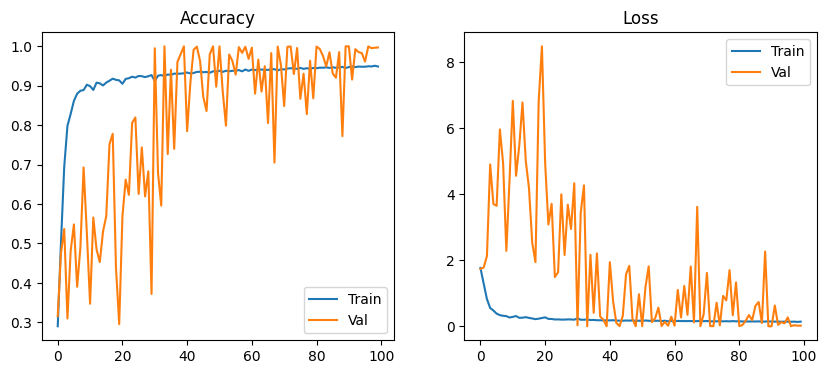

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

436/436 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Classification Report:
               precision    recall  f1-score   support

       Anger       0.99      1.00      1.00      2235
     Disgust       1.00      1.00      1.00      1856
        Fear       1.00      1.00      1.00      2264
       Happy       1.00      0.99      0.99      1604
     Neutral       0.98      1.00      0.99      1322
         Sad       1.00      0.99      1.00      2438
    Surprise       1.00      1.00      1.00      2230

    accuracy                           1.00     13949
   macro avg       1.00      1.00      1.00     13949
weighted avg       1.00      1.00      1.00     13949



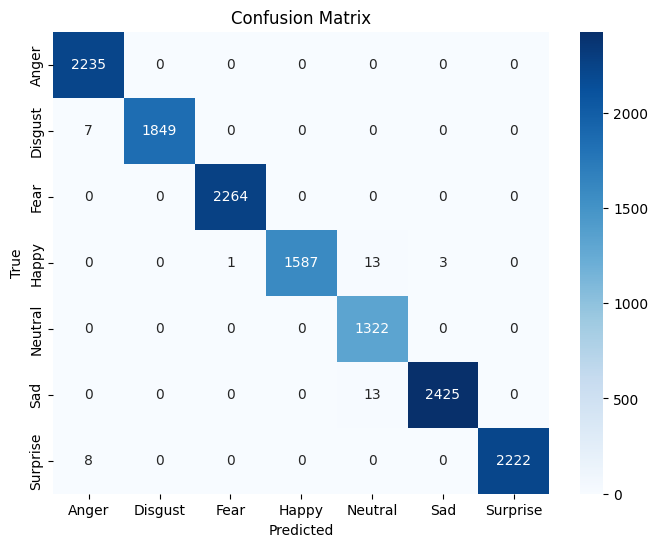

In [13]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [14]:
model.save("eeg_emotion_han_model.h5")
with open('eeg_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('eeg_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("Model and preprocessors saved.")

Model and preprocessors saved.


In [15]:
# Assuming the last column contains the class labels
df = pd.read_csv('/content/de_lds_with_labels(310 seed7).csv')

# Get the class labels (assuming the last column is the label)
y = df.iloc[:, -1]

# Get the count of each class in the dataset
class_counts = y.value_counts()

print(class_counts)


Emotion
Sad         12340
Surprise    11380
Fear        11080
Anger       10960
Disgust      9242
Happy        8100
Neutral      6640
Name: count, dtype: int64
